In [12]:
!pip install gym
!pip install keras
# !pip install wandb
# comment

In [13]:
import gym
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model
# from wandb.keras import WandbCallback

from collections import deque

# Inside my model training code
# import wandb
# wandb.init(project="my_project")

In [14]:
class DQNAgent:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):

        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        # batch size may be too big, change to double or half the amount
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        model = Sequential()
        # This is where we add the NN?
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # Make random / exploratory choice if random number smaller than current epsilon.
            return random.randrange(self.num_action_space)

        # Otherwise make exploitatory action, where the future states are predicted and an appropriate action taken.
        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):

        # replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

  

    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

Training Run 0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None
Episode: 29, total_reward: -100.00
Episode: 29, total_reward: 8.53
Episode: 29, total_reward: -100.00
Episode: 29, total_reward: -2.63
Episode: 29, total_reward: -100.00
Episode: 29, total_reward: -10.59
Episode: 29, total_reward: 1.83
Episode: 29, total_reward: -3.69
Episode: 29, total_reward: -3.58
Episode: 29, total_reward: 0.19
Episode: 29, total_rewar

Text(0, 0.5, 'Average Reward')

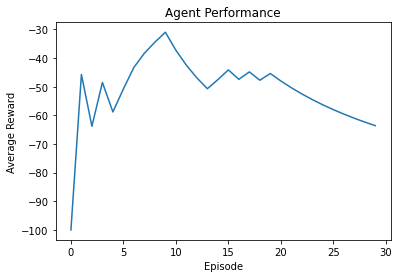

In [15]:
num_epochs = 1
run_rewards = []
env = gym.make('LunarLander-v2')
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99

# wandb.config.epsilon = 1.0
# wandb.config.epsilon_decay = 0.995
# wandb.config.gamma = 0.99

for epoch in range(num_epochs):
    print("Training Run {}".format(n))
    ep_rewards = []
    num_episodes = 30
    agent = DQNAgent(env, lr, epsilon, epsilon_decay, gamma)
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        num_steps = 100
        # wandb.log({'episode': episode, 'total_reward': total_reward})
        state = np.reshape(state, [1, agent.num_observation_space])
        total_reward += reward
        for step in range(num_steps):
            env.render()
            received_action = agent.get_action(state)
            next_state, reward, done, info = env.step(received_action)
            next_state = np.reshape(next_state, [1, agent.num_observation_space])
            agent.add_to_replay_memory(state, received_action, reward, next_state, done)
            # total_reward += reward
            state = next_state
            agent.update_counter()
            agent.learn_and_update_weights_by_reply()  
        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)

# by default, this will save to a new subfolder for files associated
# with your run, created in wandb.run.dir (which is ./wandb by default)
# wandb.save("mymodel.h5")

# you can pass the full path to the Keras model API
# model.save(os.path.join(wandb.run.dir, "mymodel.h5"))

env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
        
        

    
